In [3]:
import torch
import torch.nn as nn


class min_gru(nn.Module):
    def __init__(self, hidden_state_size, device = "cuda", dtype = torch.float32):
        super(min_gru, self).__init__()
        self.hidden_state_size = hidden_state_size
        self.dtype = dtype
        self.h = torch.randn(hidden_state_size, dtype=dtype, device=device)
        self.z = nn.Sequential(
            nn.LazyLinear(out_features=hidden_state_size, dtype=dtype,device=device),
            nn.Sigmoid()
        )
        self.h_up   = nn.LazyLinear(out_features=hidden_state_size, dtype=dtype,device=device)

    def reset_hidden(self):
        self.h = torch.zeros(self.hidden_state_size, dtype=self.dtype)

    def para_fwd(self, x):
        # x: (batch_size, seq_len, input_size)
        # h_0: (batch_size, 1, hidden_size)
        z = torch.sigmoid(self.z(x))
        h_tilde = self.h_up(x)
        h = torch.parallel_scan((1 - z),
        torch.cat([h_0, z * h_tilde], dim=1))


    def forward(self,x):
        z = torch.sigmoid(self.z(x))
        h = self.h_up(x)
        #self.h.detach_()
        self.h.data = (1 - z) * self.h + z * h
        return self.h

In [4]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
class stacked_gru(nn.Module):
    def __init__(self,input_size, device = "cuda", dtype = torch.float32):
        super(stacked_gru, self).__init__()
        self.g1 = nn.Sequential(
            min_gru(2, device=device,dtype=dtype),
            min_gru(4, device=device, dtype=dtype),
            min_gru(16, device=device, dtype=dtype),
            nn.Linear(16, input_size, device=device, dtype=dtype),
            nn.Tanh()
        )
        self.g2 = nn.Sequential(
            min_gru(32, device=device, dtype=dtype),
            min_gru(64, device=device, dtype=dtype),
            nn.Linear(64, input_size, device=device, dtype=dtype),
            nn.Tanh()
        )

        self.g3= nn.Sequential(
            min_gru(64, device=device, dtype=dtype),
            nn.Linear(64, 1, device=device, dtype=dtype),     
        )

    def reset_hidden(self):
        for s in self.g1:
            if(type(s) == type(min_gru)):
                s.reset_hidden()
        for s in self.g2:
            if(type(s) == type(min_gru)):
                s.reset_hidden()
        for s in self.g3:
            if(type(s) == type(min_gru)):
                s.reset_hidden()

    def forward(self, x):
        g1 = self.g1(x)
        g2 = self.g2(x + g1)
        g3 = self.g3(x + g2)
        return g3

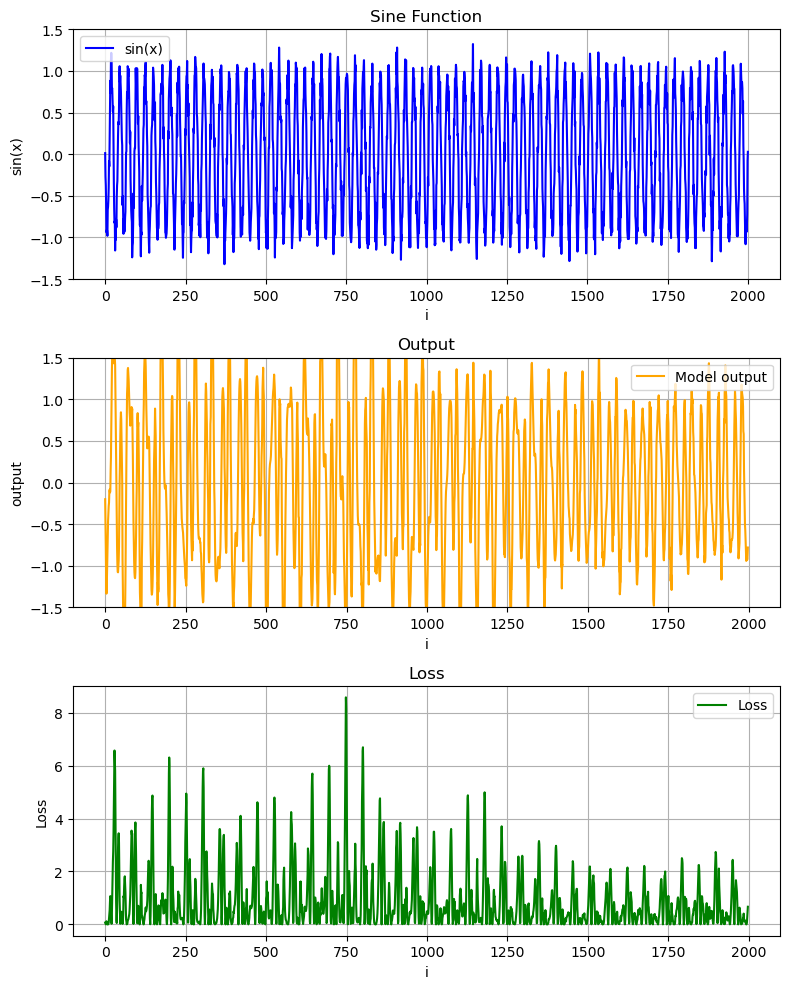

In [6]:
import torch.optim

input_size = 1
model = stacked_gru(input_size=input_size, device=device)

sample_count = 2000
freq = 50
sine = torch.sin(torch.linspace(start=0.0, end=sample_count*freq,steps=sample_count)).to(device=device)
noise = (torch.randn(sample_count) * .125).to(device=device)
samples = sine + noise

adam = torch.optim.Adam(model.parameters(), lr = 0.01)
outputs = []
losses = []
for i in range(sample_count - input_size - 1):
    y = model(samples[i:i + input_size])
    outputs.append(y.item())
    loss = (y - sine[i + input_size + 1]).pow(2).sum()
    losses.append(loss.item())
    model.zero_grad()
    loss.backward(retain_graph=True)
    adam.step()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 10))

axs[0].plot(samples.tolist(), color='blue', label='sin(x)')
axs[0].set_title('Sine Function')
axs[0].set_xlabel('i')
axs[0].set_ylim(-1.5, 1.5)
axs[0].set_ylabel('sin(x)')
axs[0].legend()
axs[0].grid()

# Plot the second graph
axs[1].plot(outputs, color='orange', label='Model output')
axs[1].set_title('Output')
axs[1].set_xlabel('i')
axs[1].set_ylim(-1.5, 1.5)
axs[1].set_ylabel('output')
axs[1].legend()
axs[1].grid()

# Plot the third graph
axs[2].plot(losses, color='green', label='Loss')
axs[2].set_title('Loss')
axs[2].set_xlabel('i')
axs[2].set_ylabel('Loss') # Limit y-axis to avoid extreme values
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

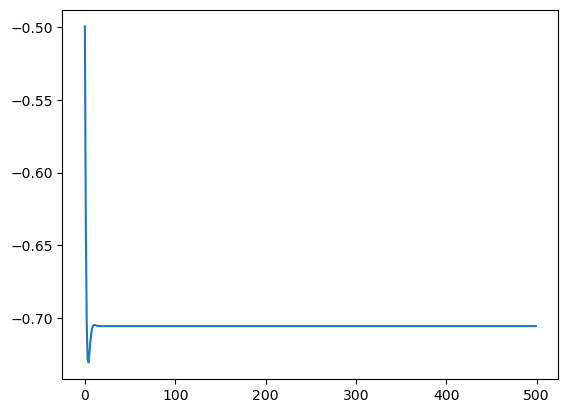

In [7]:
x = samples[:input_size]
out = []
for i in range(500):
    with torch.no_grad():
        y = model(x)
        x = torch.cat((x[1:], y))
        out.append(y.item())

plt.plot(out)

In [8]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 4947


In [9]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Number of parameters: {param.numel()}")


Layer: g1.0.z.0.weight | Size: torch.Size([2, 1]) | Number of parameters: 2
Layer: g1.0.z.0.bias | Size: torch.Size([2]) | Number of parameters: 2
Layer: g1.0.h_up.weight | Size: torch.Size([2, 1]) | Number of parameters: 2
Layer: g1.0.h_up.bias | Size: torch.Size([2]) | Number of parameters: 2
Layer: g1.1.z.0.weight | Size: torch.Size([4, 2]) | Number of parameters: 8
Layer: g1.1.z.0.bias | Size: torch.Size([4]) | Number of parameters: 4
Layer: g1.1.h_up.weight | Size: torch.Size([4, 2]) | Number of parameters: 8
Layer: g1.1.h_up.bias | Size: torch.Size([4]) | Number of parameters: 4
Layer: g1.2.z.0.weight | Size: torch.Size([16, 4]) | Number of parameters: 64
Layer: g1.2.z.0.bias | Size: torch.Size([16]) | Number of parameters: 16
Layer: g1.2.h_up.weight | Size: torch.Size([16, 4]) | Number of parameters: 64
Layer: g1.2.h_up.bias | Size: torch.Size([16]) | Number of parameters: 16
Layer: g1.3.weight | Size: torch.Size([1, 16]) | Number of parameters: 16
Layer: g1.3.bias | Size: torch